# HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


## Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**


In [3]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #To complete: compute and return z
        z_mean = inputs[0]
        z_sigma = inputs[1]

        eps = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(z_mean))
        return z_mean + tf.exp(z_sigma) * eps

## Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 

In [4]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(512, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

z_mean =  tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_var =  tf.keras.layers.Dense(latent_dim, name='z_var')(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
____________________________________________________________________________________________

## Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)


decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               402192    
Total params: 575,312
Trainable params: 575,312
Non-trainable params: 0
_____________________________________________________

## Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            bce = keras.losses.binary_crossentropy(data, reconstruction)

            reconstruction_loss = tf.math.reduce_mean(bce)*784
            kl_loss = 1 + z_var - tf.square(z_mean) - tf.exp(z_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5


            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 11s 27ms/step - loss: 197.4632 - reconstruction_loss: 195.8723 - kl_loss: 1.5909
Epoch 2/30
391/391 [==============================] - 10s 27ms/step - loss: 162.8555 - reconstruction_loss: 161.1671 - kl_loss: 1.6884
Epoch 3/30
391/391 [==============================] - 10s 27ms/step - loss: 154.5293 - reconstruction_loss: 152.7143 - kl_loss: 1.8150
Epoch 4/30
391/391 [==============================] - 10s 27ms/step - loss: 149.7057 - reconstruction_loss: 147.7837 - kl_loss: 1.9220
Epoch 5/30
391/391 [==============================] - 10s 27ms/step - loss: 150.2029 - reconstruction_loss: 148.1700 - kl_loss: 2.0328
Epoch 6/30
391/391 [==============================] - 10s 27ms/step - loss: 146.6653 - reconstruction_loss: 144.6311 - kl_loss: 2.0342
Epoch 7/30
391/391 [==============================] - 10s 27ms/step - loss: 144.8134 - reconstruction_loss: 142.7541 - kl_loss: 2.0593
Epoch 8/30
391/391 [==============================] - 1

## Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


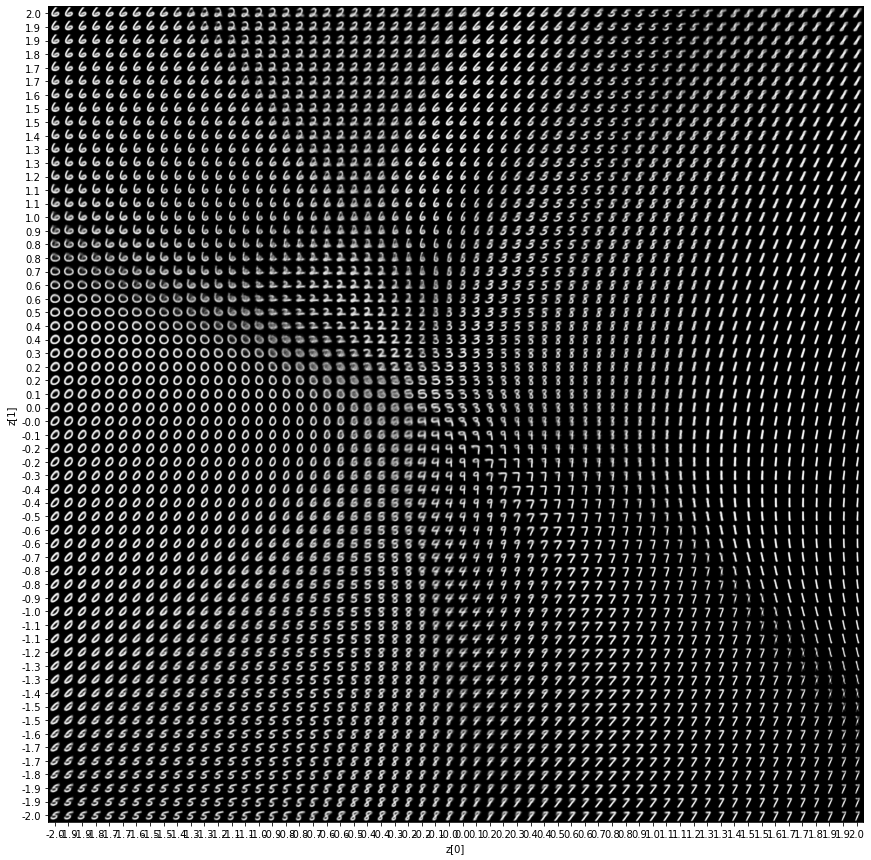

In [16]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 60) 

#To complete: explore with different "scale"

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

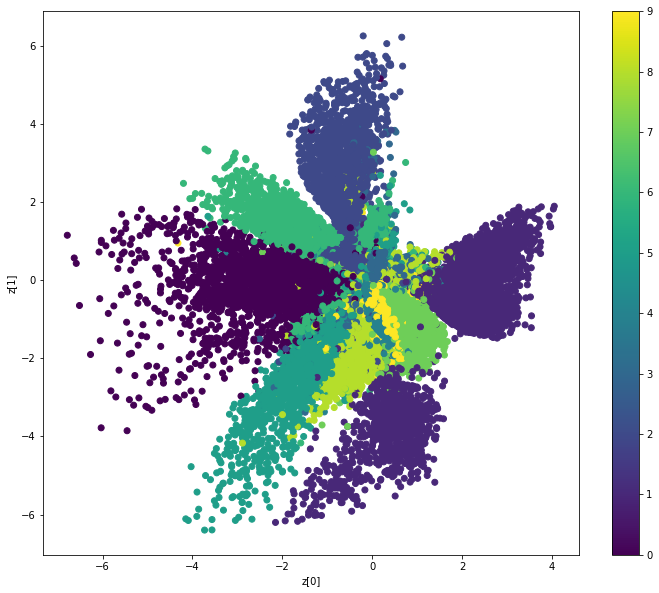

In [17]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

The first latent plot we generated displays how our model creates new digits on its own. We scan the latent plane and sample points at intervals to see the corresponding digit for each of them. This is a visualization of the latent manifold that our model created to generate these digits. Since the latent dimension we chose is 2, we can vizualize the 2-d latent plane in the label clusters plot.

Different model architectures were tested, comprised of 3, 5, 7 and 9 layers, using different combinations of activation functions (ReLU, softmax, sigmiod, tanh). The previous I have reported and vizualized is with 7. Some of the other models and results are below: 

        a. 3 Layer Model (512, 64, 512), using ReLU with sigmoid:
                - Reconstruction Loss: 136.335
                - KL Loss: 2.3840
                
        b. 3 Layer Model (512, 128, 512), using tahn with softmax: 
                - Reconstruction Loss: 548.0437
                - KL Loss: 2.1232

        c. 5 Layer Model (512, 256, 64, 256, 512), using ReLU with sigmoid: 
                - Reconstruction Loss: 137.0771 
                - KL loss: 2.3815

        d. 7 Layer Model (512, 256, 128, 32, 128, 256, 512), using tanh with sigmoid: 
                - Reconstruction Loss:  135.3872
                - KL loss: 2.3627

        e. 9 Layer Model (512, 256, 128, 64, 32, 64, 128, 256, 512), using ReLU with sigmoid:
                - Reconstruction Loss:  139.4532
                - KL loss: 2.6349

I would conclude that the combination of Relu with sigmoid gave the best results.